# Collaborative Filtering Movie Recommendations

Using Netflix-provided anonymous ratings data, the purpose here is to use collaborative filtering to predict the rating a user would give to a movie that they have not yet rated - regression problem - and so be able to generate movie recommendations - recommendation problem. The objective is to minimise the difference between predicted and actual rating, therefore the metrics of interest are RMSE and MAPE.

**Data:**       
The data can be accessed from Kaggle through the following link: https://www.kaggle.com/netflix-inc/netflix-prize-data/data

The data contains the following files:
+ combined_data_1.txt
+ combined_data_2.txt
+ combined_data_3.txt
+ combined_data_4.txt
+ movie_titles.csv

The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains movie id, with each subsequent line in the file corresponds to a rating from a customer and date the rating was made in the following format:

CustomerID,Rating,Date

Points to note about the data: 
+ MovieIDs range from 1 to 17770 sequentially.
+ CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
+ Ratings are on a five star (integral) scale from 1 to 5.
+ Dates have the format YYYY-MM-DD.

In [1]:
from tqdm import tqdm

from datetime import datetime
globalstart = datetime.now()

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')

import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

import warnings
warnings.filterwarnings("ignore")

## 1. Exploratory Data Analysis

### Preprocessing

#### Converting / Merging whole data to required format

In [2]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files = ['data/combined_data_1.txt','data/combined_data_2.txt', 
           'data/combined_data_3.txt', 'data/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # you don't have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000369


In [3]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep = ',', names = ['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by = 'date', inplace = True)
print('Done')

creating the dataframe from data.csv file..
Done

Sorting the dataframe by date..
Done


In [4]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [5]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

#### NaN values and duplicates

In [6]:
#checking for NaN values
print("Number of Nan values in df: ", sum(df.isnull().any()))

Number of Nan values in df:  0


In [7]:
#removing duplicates
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) 
print("There are {} duplicate rating entries in the data".format(dups))

There are 0 duplicate rating entries in the data


### Data statistics

In [8]:
#stats
print("Data ")
print("-"*50)
print("\nTotal number of ratings:", df.shape[0])
print("Total number of users:", len(np.unique(df.user)))
print("Total number of movies:", len(np.unique(df.movie)))

Data 
--------------------------------------------------

Total number of ratings: 100480507
Total number of users: 480189
Total number of movies: 17770


### Train:Test split and resulting dataset statistics

In [9]:
#test:train split (20:80)
if not os.path.isfile('train.csv'):
    # create df and store in disk
    df.iloc[:int(df.shape[0] * 0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0] * 0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates = ['date'])
test_df = pd.read_csv("test.csv")

In [10]:
#train data stats
print("Training data ")
print("-"*50)
print("\nTotal number of ratings in the train set:", train_df.shape[0])
print("Total number of users in the train set:", len(np.unique(train_df.user)))
print("Total number of movies in the train set:", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total number of ratings in the train set: 80384405
Total number of users in the train set: 405041
Total number of movies in the train set: 17424


In [11]:
#test set stats
print("Test data ")
print("-"*50)
print("\nTotal number of ratings in the test set:", test_df.shape[0])
print("Total number of users in the test set:", len(np.unique(test_df.user)))
print("Total number of movies in the test set:", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total number of ratings in the test set: 20096102
Total number of users in the test set: 349312
Total number of movies in the test set: 17757


### Train set EDA

In [12]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

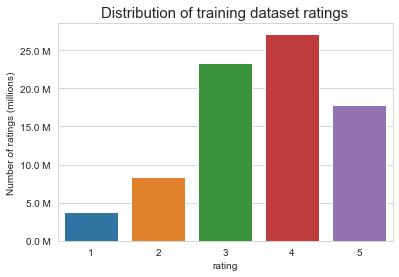

In [13]:
#ratings distribution 
fig, ax = plt.subplots()
plt.title('Distribution of training dataset ratings', fontsize = 15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Number of ratings (millions)')
plt.show()

In [14]:
#add new day-of-week column

#skip warning ''SettingWithCopyWarning''
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df.date.dt.weekday_name
train_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


#### Ratings per month

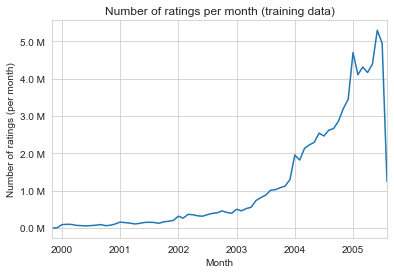

In [15]:
ax = train_df.resample('m', on = 'date')['rating'].count().plot()
ax.set_title('Number of ratings per month (training data)')
plt.xlabel('Month')
plt.ylabel('Number of ratings (per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

There is a significant and general increase in the number of ratings per month over time.

#### Movies rated per user

In [16]:
#analysis on ratings by user 
no_of_rated_movies_per_user = train_df.groupby(by = 'user')['rating'].count().sort_values(ascending = False)
no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

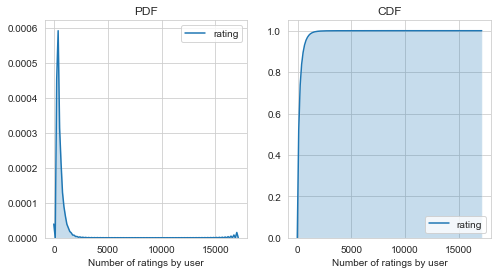

In [17]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade = True, ax = ax1)
plt.xlabel('Number of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade = True, cumulative = True, ax = ax2)
plt.xlabel('Number of ratings by user')
plt.title('CDF')
plt.show()

In [18]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

These statistics and plots show a much larger gap between the 75th and 50th percentile compared to the 25th and 50th, and an even larger gap between 75th percentile and 100%. This suggests a negative skew - a small number of users provide a large number of ratings. This will be analysed further.

In [19]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0, 1.01, 0.01), interpolation = 'higher')

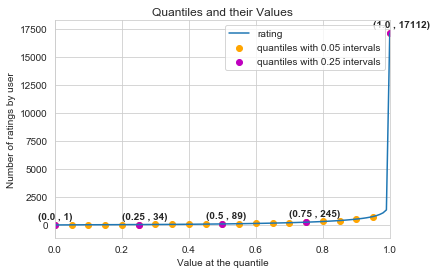

In [20]:
plt.title("Quantiles and their Values")
quantiles.plot()

#quantiles with 0.05 difference
plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = 'orange', label = "quantiles with 0.05 intervals")

#quantiles with 0.25 difference
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = 'm', label = "quantiles with 0.25 intervals")
plt.ylabel('Number of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc = 'best')

#annotate 25th, 50th, 75th and 100th percentile values
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s = "({} , {})".format(x,y), xy = (x,y), xytext = (x-0.05, y+500), fontweight = 'bold')

plt.show()

In [21]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

In [22]:
#number of ratings at the last 5% of all ratings
print('\n Number of ratings at last 5th percentile: {}\n'.format(sum(no_of_rated_movies_per_user >= 749)) )


 Number of ratings at last 5th percentile: 20305



#### Ratings per movie

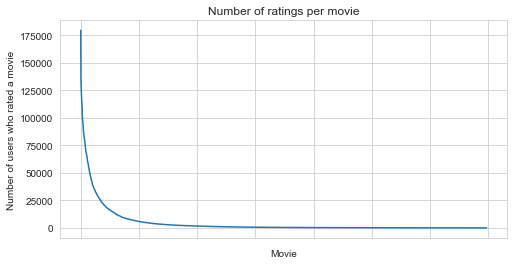

In [23]:
#analysis of ratings of a movie given by a user 
no_of_ratings_per_movie = train_df.groupby(by = 'movie')['rating'].count().sort_values(ascending = False)

fig = plt.figure(figsize = plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('Number of ratings per movie')
plt.xlabel('Movie')
plt.ylabel('Number of users who rated a movie')
ax.set_xticklabels([])

plt.show()

As for number of ratings per user, the number of users who rated a movie is very negatively skewed - most movies (around 90%) only have a small number of ratings, whereas a small number of movies (very popular) have received a very large number of ratings. 

#### Day of week

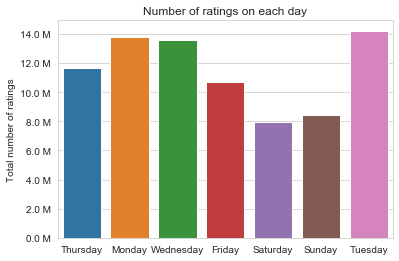

In [24]:
#number of ratings on each day of the week
fig, ax = plt.subplots()
sns.countplot(x = 'day_of_week', data = train_df, ax = ax)
plt.title('Number of ratings on each day')
plt.ylabel('Total number of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

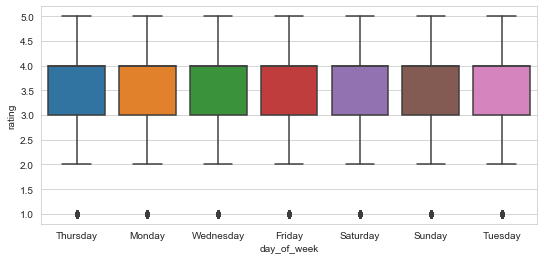

0:00:18.135134


In [25]:
start = datetime.now()
fig = plt.figure(figsize = plt.figaspect(.45))
sns.boxplot(y = 'rating', x = 'day_of_week', data = train_df)
plt.show()
print(datetime.now() - start)

In [26]:
avg_week_df = train_df.groupby(by = ['day_of_week'])['rating'].mean()
print(" Average ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 Average ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




Monday, Tuesday and Wednesday appear to be the most popular days for rating movies, with Saturday and Sunday being the least.   

The distribution of ratings des not appear to be affected by day of the week - rating distribution is very consistent (with a mean of around 3.5 for all days).

## Creating a sparse matrix for the data (train and test)

The creation of a sparse matrix means that every user-movie combination is represented. This is because the model needs to be able to predict the rating a user would give to a movie that they have not yet rated.

In [27]:
#create sparse matrix from train df
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("Present in pwd, retrieving from disk...")
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print("DONE")
else: 
    print("Creating sparse_matrix from the dataframe...")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. Shape is: (user, movie) : ',train_sparse_matrix.shape)
    print('Saving into disk for future usage...')
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('DONE\n')
print(datetime.now() - start)

Present in pwd, retrieving from disk...
DONE
0:00:03.093175


In [28]:
#find sparsity of train matrix
us, mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity of train matrix : {} % ".format((1 - (elem / (us * mv))) * 100))

Sparsity of train matrix : 99.8292709259195 % 


In [29]:
#create sparse matrix from test df
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("Present in pwd, retrieving it from disk...")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print("DONE")
else: 
    print("Creating sparse_matrix from the dataframe...")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving into disk for future usage...')
    # save it into disk
    sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('DONE\n')
    
print(datetime.now() - start)

Present in pwd, retrieving it from disk...
DONE
0:00:00.760024


In [30]:
#sparsity of test matrix
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity of test matrix: {} % ".format((1 - (elem / (us * mv))) * 100))

Sparsity of test matrix: 99.95731772988694 % 


### Averages of movie ratings, rating per user and rating per movie

In [31]:
#function to calculate user averages and create dictionary from these
def get_average_ratings(sparse_matrix, of_users): 
    # average ratings of user
    ax = 1 if of_users else 0 # 1 - User axes, 0 - Movie axes

    # .A1 is for converting Column_Matrix to 1D array 
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1
    
    # Boolean matrix of ratings (if a user rated that movie or not)
    is_rated = sparse_matrix != 0
    
    # number of ratings for each user or movie
    no_of_ratings = is_rated.sum(axis = ax).A1
    
    # max_user and max_movie ids in sparse matrix 
    u, m = sparse_matrix.shape
    
    # create dictonary of users and their average ratings
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] != 0}

    # return dictionary of average ratings
    return average_ratings

In [32]:
#global average of all movie ratings 
train_averages = dict()

# get global average of ratings in train set
train_global_average = train_sparse_matrix.sum() / train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

In [33]:
#average rating per user
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users = True)
print('\nAverage rating of user with ID 1593:', train_averages['user'][1593])


Average rating of user with ID 1593: 3.9583333333333335


In [34]:
#average rating per movie
train_averages['movie'] = get_average_ratings(train_sparse_matrix, of_users = False)
print('\nAverage rating of movie with ID 1:', train_averages['movie'][1])


Average rating of movie with ID 1: 3.7189873417721517


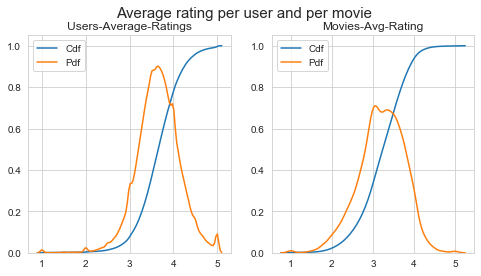

In [35]:
#PDF's and CDF's of average ratings of users and movies in train set
# pdfs for average rating per user and movie
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = plt.figaspect(.5))
fig.suptitle('Average rating per user and per movie', fontsize=15)

ax1.set_title('Users-Average-Ratings')
# get list of average user ratings from dictionary
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax = ax1, hist = False, 
             kde_kws = dict(cumulative = True), label = 'Cdf')
sns.distplot(user_averages, ax = ax1, hist = False,label = 'Pdf')

ax2.set_title('Movies-Avg-Rating')
# get list of movie_average_ratings from dictionary
movie_averages = [rat for rat in train_averages["movie"].values()]
sns.distplot(movie_averages, ax = ax2, hist = False, 
             kde_kws = dict(cumulative = True), label = 'Cdf')
sns.distplot(movie_averages, ax = ax2, hist = False, label = 'Pdf')

plt.show()

### Cold start problem

With recommendation engines, “cold start” means that circumstances are not yet optimal for the engine to provide the best possible results. Recommendation engines that run on collaborative filtering recommend each item (movie) based on user actions. The more user actions an item has, the easier it is to tell which user would be interested in it and what other items are similar to it. As time progresses, the system will be able to give more and more accurate recommendations.

This, however, brings a major contradiction and difficulty to recommendation engines. Even though the newest items are actually the most relevant ones, a recommendation system has far less confidence in recommending them to your users than it has with older items, but it’s not a good idea to let older items dominate the recommendation process.

There are two distinct categories of cold start: product cold start (here, movies) and user cold starts.

#### User cold start problem   

The user cold start means that a recommendation engine meets a new visitor for the first time. As there is no user history about them, the system doesn’t know the personal preferences of the user. Here, we can identify the number of new users.

In [36]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of users :', total_users)
print('\nNumber of users in the train data:', users_train)
print("\nNumber of users that are not in the train data: {}({} %) \n ".format(new_users, np.round((new_users / total_users) * 100, 2)))


Total number of users : 480189

Number of users in the train data: 405041

Number of users that are not in the train data: 75148(15.65 %) 
 


15.65% of users (75,148) in the full data set do not appear in the train set, therefore are new users in the test set. These will need to be dealt with.

#### Movie cold start problem

In [37]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of movies:', total_movies)
print('\nNumber of movies in train data:', movies_train)
print("\nNumber of movies that are not in the train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies / total_movies) * 100, 2)))


Total number of movies: 17770

Number of movies in train data: 17424

Number of movies that are not in the train data: 346(1.95 %) 
 


Only 1.95% (346) of the movies are new in the test set. These will also need to be dealt with.

For both the cold start user and movie problems, cosine similarity function will be used to compute similarity, both user-user and movie-movie. The top 5 similar movies and top 5 similar users will be used.

## 2. Preparing the data for modelling

### 2.1 Taking a sample of the total dataset

Due to it being computationally expensive to featurise and train a model on the entire dataset, a sample will be taken, featurised and model trained on it.

The model trained using the sampled data will not perform as well as a model trained on the entire dataset would as there are fewer users and their reactions on which to base predictions and resulting recommendations.

In [38]:
#function to extract a sample from the full dataset
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):

    # get (row, col) and (rating) tuple from sparse_matrix
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # make sure to get same sample everytime we run this programme and select without replacement
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    
    # get boolean mask or these sampled_items in originl row/col_inds
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done\n')
    
    return sample_sparse_matrix

#### Build sample train data set from train dataset

In [39]:
start = datetime.now()
path = "data/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("In pwd, retrieving from disk...")
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = path)

print(datetime.now() - start)

In pwd, retrieving from disk...
DONE
0:00:00.027016


#### Build sample test data set from test data

In [40]:
start = datetime.now()

path = "data/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("In pwd, retrieving from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = path)
print(datetime.now() - start)

In pwd, retrieving from disk....
DONE
0:00:00.020689


#### Averages of movie ratings, rating per user and rating per movie for sampled data

In [41]:
sample_train_averages = dict()

In [42]:
# get global average of ratings in train set
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.581679377504138}

In [43]:
#average rating per user
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.9655172413793105


In [44]:
#average rating per movie
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n Average rating of movie 15153 :',sample_train_averages['movie'][15153])


 Average rating of movie 15153 : 2.6458333333333335


#### Number of ratings in train and test sets

In [45]:
print('\n Number of ratings in sampled train matrix: {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n Number of ratings in sampled test matrix: {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 Number of ratings in sampled train matrix: 129286


 Number of ratings in sampled test matrix: 7333



### 2.2 Featurising the data for regression problem

#### Featurising the train data

In [46]:
# get users, movies and ratings from samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [47]:
start = datetime.now()
if os.path.isfile('data/reg_train.csv'):
    print("File already exists" )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('data/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()

            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute similar users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # ignore 'The User' from similar users
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # make it's length "5" by adding movie averages
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute similar movies to the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # ignore 'The Movie' from its similar movies.
            # get ratings of most similar movies rated by this user
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # make it's length "5" by adding user averages 
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # add other features to this data
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # actual rating of this user-movie pair
            row.append(rating)
            count = count + 1

            # add rows to the file opened
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))

print(datetime.now() - start)

File already exists
0:00:00.000608


#### Make the train dataframe from the file

The following column headers will be used:
+ user: user id
+ movie: movie id
+ GAvg: average rating of all ratings (global average)
+ Top 5 similar users ratings of this movie (sur1, sur2, sur3, sur4, sur5)
+ Top 5 similar movies rated by this user (smr1, smr2, smr3, smr4, smr5)
+ UAvg: user's average rating
+ MAvg: movie's average rating
+ rating: rating of this movie by this user

In [48]:
reg_train = pd.read_csv('data/reg_train.csv',
                        names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)

reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


#### Featurising the test data

In [49]:
# get users, movies and ratings from sample test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [50]:
start = datetime.now()

if os.path.isfile('data/reg_test.csv'):
    print("It already exists")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('data/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            try:
                # compute similar users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # ignore 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # make it's length "5" by adding movie averages 
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            except (IndexError, KeyError):
                # new User or new Movie or no ratings for given user for top similar movies
                #Cold Start Problem 
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
            except:
                print(user, movie)
                # only KeyErrors resolved. Not every Exception
                raise

            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # ignore 'The User' from its similar users.
                # get ratings of most similar movie rated by this user
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # make it's length "5" by adding user averages
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            except (IndexError, KeyError):
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add user and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            # actual rating of this user-movie pair
            row.append(rating)
            count = count + 1

            # add rows to the file opened
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')    
            
            if (count)%10000 == 0:
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("", datetime.now() - start)

It already exists


#### Make the train dataframe from the file

In [51]:
reg_test_df = pd.read_csv('data/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


### 2.3 Transforming the data for Surprise models

Surprise is a Python scikit building and analysing recommender systems that deal with explicit rating data.

To train the model in Surprise library, the format of the data needs to be changed.

In [52]:
from surprise import Reader, Dataset

#### Transform the train data

In [53]:
#specify how to read the dataframe.
reader = Reader(rating_scale=(1,5))

# create the train data from the df
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from train data, in the format from surprise library
#trainset = train_data.build_full_trainset()

#### Transform the test data

In [54]:
#tuple of user, movie, ratings
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

### 2.4 Applying Machine Learning models

The focus will be on fitting XGBoost and Surprise models. Utility functions below will assist in the training and evaluating of the algorithms.

#### Utility functions

In [55]:
#create df to store results for cv on train sets from different algorithms
kfold_train_results = pd.DataFrame(columns=['algorithm','rmse','mape'])

In [56]:
# function to calculate rmse and mape
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([(y_true[i] - y_pred[i])**2 for i in range(len(y_pred))]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape


#function to fit and predict using xgboost algorithm
def run_xgboost(algo, x_train, y_train, verbose=True):
    from sklearn.model_selection import KFold
    
    #x_vals = pd.DataFrame(columns=list(x_train.columns))
    #y_actual = pd.DataFrame(columns=['actual_rating'])
    preds = []
    rmse_lst = []
    mape_lst = []
    x_results = x_train.copy()
    
    k_fold = KFold(n_splits=10)
    
    for train_ind, test_ind in k_fold.split(x_train):
        x_train_sub = x_train.iloc[train_ind]
        y_train_sub = y_train.iloc[train_ind]
        
        x_test_sub = x_train.iloc[test_ind]
        y_test_sub = y_train.iloc[test_ind]
        
        algo.fit(x_train_sub, y_train_sub, eval_metric = 'rmse')
        predictions = algo.predict(x_test_sub)
        rmse, mape = get_error_metrics(y_test_sub.values, predictions)
        preds.append(predictions)
        #x_vals = x_vals.append(x_test_sub)
        #y_actual = y_actual.append(y_test_sub)
        rmse_lst.append(rmse)
        mape_lst.append(mape)
        
    preds = [item for sublist in preds for item in sublist]
    rmse_avg = sum(rmse_lst)/len(rmse_lst)
    mape_avg = sum(mape_lst)/len(mape_lst)
    
    #x_vals = pd.concat([x_vals, y_actual], axis=1)
    x_results['y_predictions'] = preds
    
    return x_results, rmse_avg, mape_avg


In [57]:
###functions for surprise models### 
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# function to get ratings given list of predictions (prediction is a class in Surprise).    
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

# function to get rmse and mape, given list of prediction objects 
def get_errors(predictions, print_them = False):
    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100


# function to return predicted ratings, rmse and mape of train and test data with surprise models
def run_surprise(algo, trainset, x_train): 
    from surprise.model_selection import KFold
    #start = datetime.now()
    # dictionaries that stores metrics for train and test
    #train = dict()
    #test = dict()
    
    # train algorithm with trainset
    #st = datetime.now()
    preds = []
    rmse_lst = []
    mape_lst = []
    
    k_fold = KFold(n_splits=10, shuffle=False)
    
    for train_ind, test_ind in k_fold.split(trainset):
        
        algo.fit(train_ind)
        
        test_preds = algo.test(test_ind)
        
        # get predicted ratings from list of predictions
        test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    
        # get error metrics from predicted and actual ratings
        test_rmse, test_mape = get_errors(test_preds)
        
        preds.append(test_pred_ratings)
        rmse_lst.append(test_rmse)
        mape_lst.append(test_mape)
        
    preds = [item for sublist in preds for item in sublist]
    rmse_avg = sum(rmse_lst)/len(rmse_lst)
    mape_avg = sum(mape_lst)/len(mape_lst)
    
    x_train['y_predictions'] = preds
        

    return x_train, rmse_avg, mape_avg

The following algorithms and features will be fit on the train data and tested on the test data:
+ XGBoost with 13 features (sur1, sur2, sur3, sur4, sur5, smr1, smr2, smr3, smr4, smr5, GAvg, UAvg, and MAvg)
+ Surprise BaselineModel

#### 2.4.1 XGBoost with 13 features

In [58]:
from matplotlib import pyplot
%matplotlib inline
import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

In [59]:
# prepare train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [60]:
#parameter optimisation using randomisedsearchcv
params = {'learning_rate':stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':stats.uniform(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}


# initialise XGBoost model
xgbreg = xgb.XGBRegressor(silent = True, n_jobs = 13, random_state = 15)
start = datetime.now()
print('Tuning parameters: \n')

xgb_best = RandomizedSearchCV(xgbreg, params, refit = False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print('Best XGBoost parameters: ', best_para)

first_xgb = xgbreg.set_params(**best_para)
print('Time taken to tune:{}\n'.format(datetime.now()-start))

Tuning parameters: 

Best XGBoost parameters:  {'colsample_bytree': 0.7051546153524784, 'gamma': 0.011865153262857725, 'learning_rate': 0.17421720439840674, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 657, 'reg_alpha': 83, 'reg_lambda': 83.99636401947468, 'subsample': 0.7612969736040649}
Time taken to tune:0:03:13.112119



In [61]:
train_results, xgb_rmse, xgb_mape = run_xgboost(first_xgb, x_train, y_train)

# store results in df
xgb1_results = ['xgb_13_features', xgb_rmse, xgb_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb1_results, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679


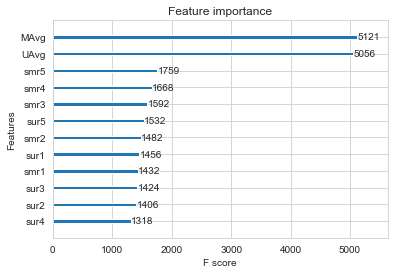

In [62]:
# plot feature importance
xgb.plot_importance(first_xgb)
plt.show()

#### 2.4.2 Surprise BaselineOnly

The BaselineOnly predicts the baseline estimate for given user and item. It is a basic algorithm that does not do  much work, but is useful for comparing accuracies.    

Parameters to set are:
+ bsl_options (dict) - a dictionary of options for the baseline estimates computation. Baselines can be estimated using either stochastic gradient descent (SGD) or alternating least squares (ALS)
+ verbose (bool)

In [63]:
from surprise import BaselineOnly

In [64]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }

bsl_algo = BaselineOnly(bsl_options = bsl_options)

# run algorithm
add_cols_train, rmse_bsl, mape_bsl = run_surprise(bsl_algo, train_data, x_train)

bsl_lst = ['bsl_surprise', rmse_bsl, mape_bsl]

add_cols_train = add_cols_train.rename(columns={'y_predictions': 'bsl_pred'})

# store error metrics
kfold_train_results = kfold_train_results.append(pd.Series(bsl_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223


#### 2.4.3 Surprise KNNBaseline

This is a basic collaborative filtering algorithm that takes into account a baseline rating. For this, the feature on which similarities are to be computed is specified. Considered here will be user-user (user_based=True) and movie-movie (user_based=False) similarities. Whether similarities are based on users or items will have a significant impact on the performance of the prediction algorithm, hence testing it with both to see which performs best.

For the best predictions, the documentation recommends using pearson_baseline (with which is the parameter option of shrinkage). The min_support, or minimum number of common items (when user_based=True) or minimum number of common users (when user_based=False) for similarity not to be zero is also specified.

**2.4.3.1 Surprise KNNBaseline User-User Similarities**

In [65]:
from surprise import KNNBaseline

In [67]:
# specify how to compute similarities and what to consider with sim_options
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# keep other parameters as default
bsl_options = {'method': 'sgd'} 

knn_u_algo = KNNBaseline(k = 40, sim_options = sim_options, bsl_options = bsl_options)

add_cols_train2, rmse_knn_u, mape_knn_u = run_surprise(knn_u_algo, train_data, add_cols_train)

knn_u_lst = ['knn_bsl_u', rmse_knn_u, mape_knn_u]

add_cols_train2 = add_cols_train2.rename(columns={'y_predictions': 'knn_bsl_u'})

# store error metrics
kfold_train_results = kfold_train_results.append(pd.Series(knn_u_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556


**2.4.3.1 Surprise KNNBaseline Movie-Movie Similarities**

In [68]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 

bsl_options = {'method': 'sgd'}

knn_m_algo = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

add_cols_train3, rmse_knn_m, mape_knn_m = run_surprise(knn_m_algo, train_data, add_cols_train2)

knn_m_lst = ['knn_bsl_m', rmse_knn_m, mape_knn_m]

add_cols_train3 = add_cols_train3.rename(columns={'y_predictions': 'knn_bsl_m'})

# store error metrics
kfold_train_results = kfold_train_results.append(pd.Series(knn_m_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline si

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008


#### 2.4.4 Matrix Factorisation

The SVD algorithm, when baselines are not used, is equivalent to Probabilistic Matrix Factorisation. It additionally models the user and item biases from users and items. To estimate all the unknown, the regularised squared error is minimised by performing stochastic gradient descent.

**2.4.4.1 SVD Matrix Factorisation User-Movie Interactions**

In [69]:
from surprise import SVD

In [70]:
# initialise model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
add_cols_train4, rmse_svd, mape_svd = run_surprise(svd, train_data, add_cols_train3)

svd_lst = ['svd', rmse_svd, mape_svd]

add_cols_train4 = add_cols_train4.rename(columns={'y_predictions': 'svd'})

# store error metrics
kfold_train_results = kfold_train_results.append(pd.Series(svd_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057


**2.4.4.2 SVD Matrix Factorisation with implicit feedback from user (user-rated movies)**    

SVDpp factors the neighborhood model, thus making both item-item and user-user implementations scale linearly with the size of the data.

In [71]:
from surprise import SVDpp

In [72]:
# initialise model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)

add_cols_train5, rmse_svdpp, mape_svdpp = run_surprise(svdpp, train_data, add_cols_train4)

svdpp_lst = ['svdpp', rmse_svdpp, mape_svdpp]

add_cols_train5 = add_cols_train5.rename(columns={'y_predictions': 'svdpp'})

# store error metrics
kfold_train_results = kfold_train_results.append(pd.Series(svdpp_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8


,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493


#### 2.4.5 Enhancing XGBoost

Now that additional features have been generated through Surprise, these can be included within the x training set to see if it improves the XGBoost performance on the data. The following combinations will be trialled using the training set and kfold:
+ All Surprise features
+ 13 features and all Surprise features
+ 13 features and BaselineOnly
+ 13 features and KNN features
+ 13 features and Matrix Factorisation features
+ 13 features, BaselineOnly and Matrix Factorisation features
+ 13 features, KNN and Matrix Factorisation features
+ 13 features, KNN and BaselineOnly features

This will use the predictions generated for the train set resulting from K-fold cross validation; if the predictions for the train set were generated following training of the model on the entire training set, as the model has seen the data, this would mean predictions are likely to be more accurate than they would be on unseen data, and would thus be more likely to overfit to the training data, and reduce performance on the test set. By making predictions on the training data through kfold, the predictions are on unseen data and so will be closer to those predictions generated for the test data set, hopefully making the model more generalisable to unseen data.

Bias has likely still entered through the KFold cross validation prediction generation as the similarity scores within the train set can be known, whereas those for the test data are based off of the train data.

In [73]:
add_cols_train5.head()

,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,bsl_pred,knn_bsl_u,knn_bsl_m,svd,svdpp
0,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,3.479352,3.403231,3.403231,3.480531,3.549828
1,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3.560876,3.466196,3.466196,3.428499,3.483650
2,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,3.685781,3.725061,3.725061,3.637396,3.676326
3,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,3.624363,3.671701,3.671701,3.632480,3.538204
4,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,3.569712,3.501260,3.501260,3.492751,3.543125


**2.4.5.1 XGBoost with Surprise predictions only**

In [75]:
# prepare train data
x_train = add_cols_train5[['bsl_pred', 'knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':sp_randint(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit = False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)

Tuning parameters: 

{'colsample_bytree': 0.7302065014679269, 'gamma': 0.002583173905988181, 'learning_rate': 0.053080673819263666, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 495, 'reg_alpha': 137, 'reg_lambda': 26, 'subsample': 0.7920856054423232}


In [76]:
xgb_all_surprise = xgbreg.set_params(**best_para)
xgb_surprise_results, xgb_surprise_rmse, xgb_surprise_mape = run_xgboost(xgb_all_surprise, x_train, y_train)

# store results in df
xgb_surprise_results = ['xgb_surprise_only', xgb_surprise_rmse, xgb_surprise_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb_surprise_results, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493
6,xgb_surprise_only,1.003360,31.688790


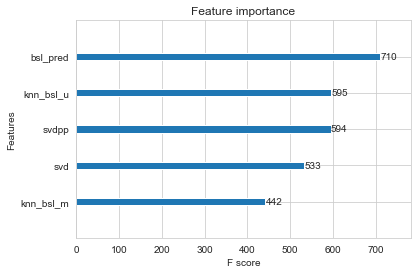

In [77]:
xgb.plot_importance(xgb_all_surprise)
plt.show()

The above RMSE and MAPE values shows that using XGBoost on Surprise-generated predictions only is an improvement on the scores obtained for the Surprise predictions alone. Now we will see if adding these features to the 13 features results in a futher improvement to the XGBoost performance.

**2.4.5.2 XGBoost with 13 features and BaselineOnly**

In [82]:
# prepare train data
x_train = add_cols_train5.drop(['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp'], axis=1)
y_train = reg_train['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':sp_randint(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit = False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)

Tuning parameters: 

{'colsample_bytree': 0.7329005313787988, 'gamma': 0.014417086291996053, 'learning_rate': 0.08095821306018394, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 794, 'reg_alpha': 74, 'reg_lambda': 86, 'subsample': 0.9849941844116756}


In [83]:
xgb_bsl = xgbreg.set_params(**best_para)
xgb_bsl_results, xgb_bsl_rmse, xgb_bsl_mape = run_xgboost(xgb_bsl, x_train, y_train)

# store results in df
xgb_bsl_lst = ['xgb_bsl', xgb_bsl_rmse, xgb_bsl_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb_bsl_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493
6,xgb_surprise_only,1.003360,31.688790
7,xgb_all,0.830989,24.706597
8,xgb_bsl,0.828816,24.537363


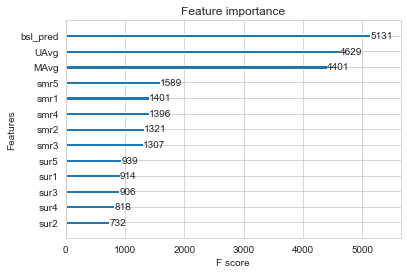

In [85]:
xgb.plot_importance(xgb_bsl)
plt.show()

**2.4.5.3 XGBoost with 13 features and KNN features**

In [86]:
# prepare train data
x_train = add_cols_train5.drop(['bsl_pred', 'svd', 'svdpp'], axis=1)
y_train = reg_train['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':sp_randint(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit = False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)

Tuning parameters: 

{'colsample_bytree': 0.6327461928865011, 'gamma': 0.016471909528871006, 'learning_rate': 0.047068284900700114, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 867, 'reg_alpha': 144, 'reg_lambda': 61, 'subsample': 0.9766104604819289}


In [87]:
xgb_knn = xgbreg.set_params(**best_para)
xgb_knn_results, xgb_knn_rmse, xgb_knn_mape = run_xgboost(xgb_knn, x_train, y_train)

# store results in df
xgb_knn_lst = ['xgb_knn', xgb_knn_rmse, xgb_knn_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb_knn_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493
6,xgb_surprise_only,1.003360,31.688790
7,xgb_all,0.830989,24.706597
8,xgb_bsl,0.828816,24.537363
9,xgb_knn,0.837235,24.938951


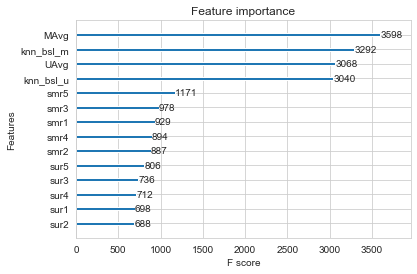

In [88]:
xgb.plot_importance(xgb_knn)
plt.show()

**2.4.5.4 XGBoost with 13 features and Matrix Factorisation features**

In [89]:
# prepare train data
x_train = add_cols_train5.drop(['bsl_pred', 'knn_bsl_u', 'knn_bsl_m'], axis=1)
y_train = reg_train['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':sp_randint(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit = False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)

Tuning parameters: 

{'colsample_bytree': 0.8821131761924837, 'gamma': 0.0025637321642454024, 'learning_rate': 0.04261209034545674, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 586, 'reg_alpha': 19, 'reg_lambda': 119, 'subsample': 0.727632275441892}


In [90]:
xgb_mf = xgbreg.set_params(**best_para)
xgb_mf_results, xgb_mf_rmse, xgb_mf_mape = run_xgboost(xgb_mf, x_train, y_train)

# store results in df
xgb_mf_lst = ['xgb_mf', xgb_mf_rmse, xgb_mf_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb_mf_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493
6,xgb_surprise_only,1.003360,31.688790
7,xgb_all,0.830989,24.706597
8,xgb_bsl,0.828816,24.537363
9,xgb_knn,0.837235,24.938951


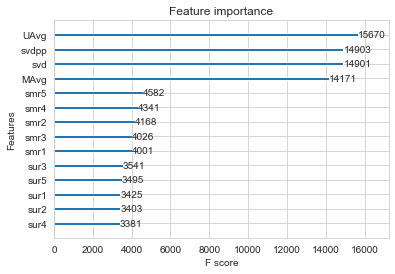

In [91]:
xgb.plot_importance(xgb_mf)
plt.show()

**2.4.5.5 XGBoost with 13 features, BaselineOnly and KNN features**

In [92]:
# prepare train data
x_train = add_cols_train5.drop(['svd', 'svdpp'], axis=1)
y_train = reg_train['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':sp_randint(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit = False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)

Tuning parameters: 

{'colsample_bytree': 0.7601837334821601, 'gamma': 0.008642198427714933, 'learning_rate': 0.12481998805151001, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 688, 'reg_alpha': 73, 'reg_lambda': 17, 'subsample': 0.804168614072467}


In [93]:
xgb_bsl_knn = xgbreg.set_params(**best_para)
xgb_bsl_knn_results, xgb_bsl_knn_rmse, xgb_bsl_knn_mape = run_xgboost(xgb_bsl_knn, x_train, y_train)

# store results in df
xgb_bsl_knn_lst = ['xgb_bsl_knn', xgb_bsl_knn_rmse, xgb_bsl_knn_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb_bsl_knn_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493
6,xgb_surprise_only,1.003360,31.688790
7,xgb_all,0.830989,24.706597
8,xgb_bsl,0.828816,24.537363
9,xgb_knn,0.837235,24.938951


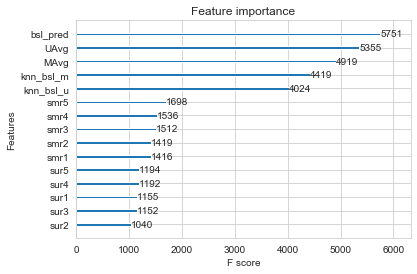

In [94]:
xgb.plot_importance(xgb_bsl_knn)
plt.show()

**2.4.5.6 XGBoost with 13 features, BaselineOnly and Matrix Factorisation features**

In [95]:
# prepare train data
x_train = add_cols_train5.drop(['knn_bsl_u', 'knn_bsl_m'], axis=1)
y_train = reg_train['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':sp_randint(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit = False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)

Tuning parameters: 

{'colsample_bytree': 0.8045031646059833, 'gamma': 0.0019342729474891996, 'learning_rate': 0.07780597336839709, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 533, 'reg_alpha': 50, 'reg_lambda': 62, 'subsample': 0.9783077721295773}


In [96]:
xgb_bsl_mf = xgbreg.set_params(**best_para)
xgb_bsl_mf_results, xgb_bsl_mf_rmse, xgb_bsl_mf_mape = run_xgboost(xgb_bsl_mf, x_train, y_train)

# store results in df
xgb_bsl_mf_lst = ['xgb_bsl_mf', xgb_bsl_mf_rmse, xgb_bsl_mf_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb_bsl_mf_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493
6,xgb_surprise_only,1.003360,31.688790
7,xgb_all,0.830989,24.706597
8,xgb_bsl,0.828816,24.537363
9,xgb_knn,0.837235,24.938951


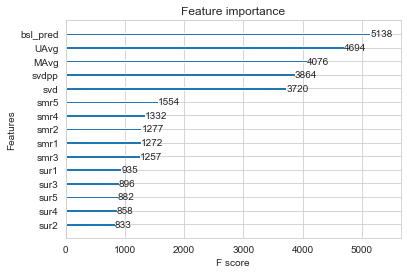

In [97]:
xgb.plot_importance(xgb_bsl_mf)
plt.show()

**2.4.5.7 XGBoost with 13 features, KNN and Matrix Factorisation features**

In [98]:
# prepare train data
x_train = add_cols_train5.drop(['bsl_pred'], axis=1)
y_train = reg_train['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':sp_randint(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}

xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit = False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)

Tuning parameters: 

{'colsample_bytree': 0.8962128845774056, 'gamma': 0.011900106085863851, 'learning_rate': 0.018646203364947347, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 926, 'reg_alpha': 67, 'reg_lambda': 34, 'subsample': 0.9062772354752066}


In [99]:
xgb_knn_mf = xgbreg.set_params(**best_para)
xgb_knn_mf_results, xgb_knn_mf_rmse, xgb_knn_mf_mape = run_xgboost(xgb_knn_mf, x_train, y_train)

# store results in df
xgb_knn_mf_lst = ['xgb_knn_mf', xgb_knn_mf_rmse, xgb_knn_mf_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb_knn_mf_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493
6,xgb_surprise_only,1.003360,31.688790
7,xgb_all,0.830989,24.706597
8,xgb_bsl,0.828816,24.537363
9,xgb_knn,0.837235,24.938951


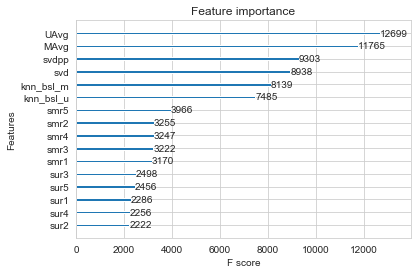

In [100]:
xgb.plot_importance(xgb_knn_mf)
plt.show()

**2.4.5.8 XGBoost with 13 features + all surprise predictions**

In [79]:
# prepare x_train and y_train
x_train = add_cols_train5.copy()
y_train = reg_train['rating']

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':stats.uniform(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}


xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit=False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)
xgb_all = xgbreg.set_params(**best_para)
print('Time taken to tune:{}\n'.format(datetime.now()-start))

Tuning parameters: 

{'colsample_bytree': 0.6808447611501808, 'gamma': 0.005283724107939103, 'learning_rate': 0.05955255201488671, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 672, 'reg_alpha': 107, 'reg_lambda': 85.42922429053384, 'subsample': 0.9080413267115341}
Time taken to tune:0:04:16.133483



In [80]:
xgb_all_results, xgb_all_rmse, xgb_all_mape = run_xgboost(xgb_all, x_train, y_train)

# store results in df
xgb_all_lst = ['xgb_all', xgb_all_rmse, xgb_all_mape]
kfold_train_results = kfold_train_results.append(pd.Series(xgb_all_lst, index = kfold_train_results.columns), ignore_index=True)
kfold_train_results

,algorithm,rmse,mape
0,xgb_13_features,0.842627,25.041679
1,bsl_surprise,1.019674,32.729223
2,knn_bsl_u,1.004814,31.452556
3,knn_bsl_m,1.008868,31.401008
4,svd,1.006655,31.553057
5,svdpp,1.006912,31.477493
6,xgb_surprise_only,1.003360,31.688790
7,xgb_all,0.830989,24.706597


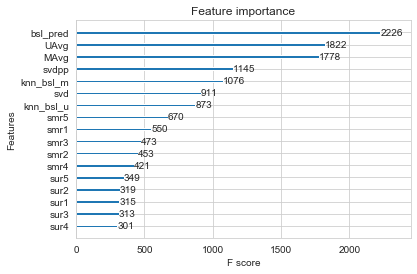

In [81]:
xgb.plot_importance(xgb_all)
plt.show()

### 3. Comparing models

In [102]:
kfold_train_results.sort_values(by='rmse')

,algorithm,rmse,mape
11,xgb_bsl_knn,0.822528,24.247961
12,xgb_bsl_mf,0.822970,24.281804
10,xgb_mf,0.828671,24.464107
8,xgb_bsl,0.828816,24.537363
7,xgb_all,0.830989,24.706597
13,xgb_knn_mf,0.831343,24.639751
9,xgb_knn,0.837235,24.938951
0,xgb_13_features,0.842627,25.041679
6,xgb_surprise_only,1.003360,31.688790
2,knn_bsl_u,1.004814,31.452556


From the above, XGBoost with the 13 features, plus BaselineOnly and KNN features has the lowest RMSE on the train data from KFold cross validation, thus it is the best performed on the train data. 

The entire train set will now be used to build the BaselineOnly and KNN models to generate predictions on the test test, and the XGBoost with the above-mentioned features will be trained on the entire training set. This final model will then be used to make predictions on the test data.

### 4. Building the final model and predicting on the test set

The add_cols_train5 dataframe will be used to train the XGBoost model as because the Surprise features were generated using KFold cross validation, they should reduce the bias and likelihood of overfitting on the model. However, to generate predictions for the Surprise features for the test set, the entire training set will be used.

The following steps need to be taken: 
1. Train Surprise BaselineOnly and generate predictions on the test set
2. Train Surprise KNNBaseline user-user and movie-movie similarities and generate predictions on the test set
3. Train XGBoost with the 13 features, and BaselineOnly and KNN features

#### 4.1 Utility functions

In [126]:
#specify how to read the dataframe.
reader = Reader(rating_scale=(1,5))
# create the train data from the df
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
# build the trainset from train data, in the format from surprise library
trainset = train_data.build_full_trainset()

#create test data sets for Surprise - tuple of user, movie, ratings
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

#create test df's
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

In [127]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

def run_xgboost(algo, x_train, y_train, x_test, y_test, verbose=True):
    # dictionary for storing test results
    test_results = dict()
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return test results
    return test_results


In [128]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100


def run_surprise(algo, trainset, testset, x_test): 

    start = datetime.now()
    
    x_test_features = x_test.copy()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    #Evaluating Test data
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    x_test_features['y_pred'] = test_pred_ratings
    
    # return predictions, rmse and mape
    return x_test_features, test_rmse, test_mape

#### 4.2 BaselineOnly predictions

In [129]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }

bsl_algo = BaselineOnly(bsl_options = bsl_options)

# run algorithm
x_test_features1, rmse_bsl, mape_bsl = run_surprise(bsl_algo, trainset, testset, x_test)

#bsl_lst = ['bsl_surprise', rmse_bsl, mape_bsl]

x_test_features1 = x_test_features1.rename(columns={'y_pred': 'bsl_pred'})

# store error metrics
#kfold_train_results = kfold_train_results.append(pd.Series(bsl_lst, index = kfold_train_results.columns), ignore_index=True)
#kfold_train_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.827610 


Evaluating for test data...
time taken : 0:00:00.063728


#### 4.3 KNNBaseline predictions

In [130]:
# specify how to compute similarities and what to consider with sim_options
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# keep other parameters as default
bsl_options = {'method': 'sgd'} 

knn_u_algo = KNNBaseline(k = 40, sim_options = sim_options, bsl_options = bsl_options)

x_test_features2, rmse_knn_u, mape_knn_u = run_surprise(knn_u_algo, trainset, testset, x_test_features1)

#knn_u_lst = ['knn_bsl_u', rmse_knn_u, mape_knn_u]

x_test_features2 = x_test_features2.rename(columns={'y_pred': 'knn_bsl_u'})

# store error metrics
#kfold_train_results = kfold_train_results.append(pd.Series(knn_u_lst, index = kfold_train_results.columns), ignore_index=True)
#kfold_train_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:26.039141 


Evaluating for test data...
time taken : 0:00:00.081375


In [131]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 

bsl_options = {'method': 'sgd'}

knn_m_algo = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

x_test_features3, rmse_knn_m, mape_knn_m = run_surprise(knn_m_algo, trainset, testset, x_test_features2)

#knn_m_lst = ['knn_bsl_m', rmse_knn_m, mape_knn_m]

x_test_features3 = x_test_features3.rename(columns={'y_pred': 'knn_bsl_m'})

# store error metrics
#kfold_train_results = kfold_train_results.append(pd.Series(knn_m_lst, index = kfold_train_results.columns), ignore_index=True)
#kfold_train_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:01.049357 


Evaluating for test data...
time taken : 0:00:00.061387


#### 4.4 XGBoost predictions on the test set

In [133]:
# prepare x_train, y_train and x_test
x_train = add_cols_train5.drop(['svd', 'svdpp'], axis=1)
y_train = reg_train['rating']

x_test = x_test_features3.copy()

params = {'learning_rate' :stats.uniform(0.01,0.2),
             'n_estimators':sp_randint(100,1000),
             'max_depth':sp_randint(1,10),
             'min_child_weight':sp_randint(1,8),
             'gamma':stats.uniform(0,0.02),
             'subsample':stats.uniform(0.6,0.4),
             'reg_alpha':sp_randint(0,200),
             'reg_lambda':stats.uniform(0,200),
             'colsample_bytree':stats.uniform(0.6,0.3)}


xgbreg = xgb.XGBRegressor(silent=True, n_jobs=13, random_state=15)
start = datetime.now()
print('Tuning parameters: \n')
xgb_best = RandomizedSearchCV(xgbreg, params, refit=False, scoring = "neg_mean_squared_error", cv = 3)
xgb_best.fit(x_train, y_train)
best_para = xgb_best.best_params_
print(best_para)
xgb_all = xgbreg.set_params(**best_para)
print('Time taken to tune:{}\n'.format(datetime.now()-start))

Tuning parameters: 

{'colsample_bytree': 0.7051546153524784, 'gamma': 0.011865153262857725, 'learning_rate': 0.17421720439840674, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 657, 'reg_alpha': 83, 'reg_lambda': 83.99636401947468, 'subsample': 0.7612969736040649}
Time taken to tune:0:04:04.850863



#### 4.5 Performance of the model on the test set

In [134]:
xgb_bsl_knn = xgbreg.set_params(**best_para)
test_results = run_xgboost(xgb_bsl_knn, x_train, y_train, x_test, y_test)

Training the model..
Done. Time taken : 0:00:39.747367

Done 

Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0762143094436507
MAPE :  34.976035372669784
